this notebook partially reproduces Figure 4 of the 2011 paper.

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy.io import loadmat

from torchvision.utils import make_grid
from torch import FloatTensor

from pc_v1 import dir_dictionary
from pc_v1 import io, core

In [3]:
# first, show all the filters.
w_ff_on, w_ff_off = io.dim_conv_v1_filter_definitions()

In [4]:
# adapted from <https://github.com/leelabcnbc/cnn-v1-jcns2018/blob/master/fig7_cnn.ipynb>
def imshow_pytorch(npimg, figsize=(8, 6), title=None):
    plt.close('all')
    plt.figure(figsize=figsize)
    img_to_show = np.transpose(npimg.numpy(), (1, 2, 0))
    plt.imshow(img_to_show)
    plt.axis('off')
    if title is not None:
        plt.title(title)

    plt.show()

In [5]:
def plot_groups_of_lines(xdata, data, names, style, *, ax=None, xlog=False):
    if ax is None:
        ax = plt.gca()
    assert len(data) == len(names)

    if isinstance(style, str):
        style = [style]*len(data)
    assert len(data) == len(names)

    for idx, (data_this, name_this, style_this) in enumerate(zip(data, names, style)):
        ax.plot(xdata, data_this, label=name_this, linewidth=(idx+1)*2,
                 marker=style_this)
    
    if xlog:
        ax.set_xscale('log')
    
    ax.legend(loc='best')

In [6]:
def process_im_stack(ims, gain=10, nonlinear=True):
    x_on_stack = []
    x_off_stack = []
    
    for im in ims:
        x_on, x_off = io.preprocess_image(im, gain=gain, nonlinear=nonlinear)
        x_on_stack.append(x_on)
        x_off_stack.append(x_off)
    x_on_stack = np.asarray(x_on_stack)
    x_off_stack = np.asarray(x_off_stack)
    return x_on_stack, x_off_stack

In [7]:
# fig 5a. basic tuning properties.
# mostly copied from `test_v1_orientation_tuning_contrast` of `/debug/V1_ResponseProperties/test_core.py`
def fig4b():
    
    grating_wavel = 6
    patch_diam = 11
    gap = 2
    image_size = 3 * patch_diam + 2 * gap
    contrast = 1
    phase = 0
    im_all = []
    for test in range(2):
        # first, test, no change.
        # second there is change, from dislike to like (for center)
        
        for t in range(2):
            if t == 0:
                im_this = io.image_centre_surround(patch_diam, gap, 0.5 * (image_size - patch_diam),
                                                   grating_wavel, grating_wavel, 90, 90, phase, phase,
                                                   contrast, contrast)
            else:
                assert t == 1
                if test == 0:
                    im_this = io.image_centre_surround(patch_diam, gap, 0.5 * (image_size - patch_diam),
                                                       grating_wavel, grating_wavel, 90, 90, phase, phase,
                                                       contrast, contrast)
                else:
                    assert test == 1
                    im_this = io.image_centre_surround(patch_diam, gap, 0.5 * (image_size - patch_diam),
                                                       grating_wavel, grating_wavel, 0, 90, phase, phase,
                                                       contrast, contrast)
                    
            im_all.append(im_this.copy())
    
    # here I show the actual images.
    # in the paper, those images are transposed, as noted in the paper
    # 
    # pp. 566 top.
    # A grating at 0° is shown as vertical in the icons used in the figures in Section 3
    # (however, note that a grating at 0° is shown as horizontal in Spratling (2010)).
    #
    # also, check the code.
    
    imshow_pytorch(make_grid(FloatTensor(np.asarray(im_all)[:,np.newaxis]),
                             nrow=2, normalize=False),
                   title='test images', figsize=(16, 5))
    
    
    # 26 first image and 15 second images.
    frame1 = 26
    frame2 = 15
    im_frames_test1 = np.concatenate([np.broadcast_to(im_all[0], (frame1,) + im_all[0].shape),
                                     np.broadcast_to(im_all[1], (frame2,) + im_all[1].shape)])
    im_frames_test2 = np.concatenate([np.broadcast_to(im_all[2], (frame1,) + im_all[2].shape),
                                     np.broadcast_to(im_all[3], (frame2,) + im_all[3].shape)])
    model_names = ('full', 'no_lgn', 'no_inhibition')
    
    
    plt.close('all')
    fig, axes = plt.subplots(1,len(model_names),sharex=True, sharey=True, figsize=(20, 10))
    for ax, model_type in zip(axes, model_names):
        print(model_type)
        if model_type == 'full':
            # prepare all images.
            x_on, x_off = process_im_stack(im_frames_test1)
            #
            y1 = core.dim_conv(w_ff_on, w_ff_off, x_on, x_off, iterations=41, epsilon2=500*0.0001*5000,
                              verbose=False)
            
            
            x_on, x_off = process_im_stack(im_frames_test2)
            #
            y2 = core.dim_conv(w_ff_on, w_ff_off, x_on, x_off, iterations=41, epsilon2=500*0.0001*5000,
                              verbose=False)
            
            
            
        elif model_type == 'no_lgn':
            
            x_on, x_off = process_im_stack(im_frames_test1, nonlinear=False)
            #
            y1 = core.dim_conv(w_ff_on, w_ff_off, x_on, x_off, iterations=41, epsilon2=500*0.0001*5000,
                              verbose=False)
            
            x_on, x_off = process_im_stack(im_frames_test2, nonlinear=False)
            #
            y2 = core.dim_conv(w_ff_on, w_ff_off, x_on, x_off, iterations=41, epsilon2=500*0.0001*5000,
                              verbose=False)
        elif model_type == 'no_inhibition':
            x_on, x_off = process_im_stack(im_frames_test1)
            #
            y1 = core.dim_conv(w_ff_on, w_ff_off, x_on, x_off, iterations=41, epsilon2=500*0.0001*5000, 
                             linear=True,
                              verbose=False)
            x_on, x_off = process_im_stack(im_frames_test2)
            y2 = core.dim_conv(w_ff_on, w_ff_off, x_on, x_off, iterations=41, epsilon2=500*0.0001*5000, 
                             linear=True,
                              verbose=False)
        else:
            raise ValueError
        
        # then take useful part
        assert y1.shape == y2.shape == (41,32,41,41)
        y1 = y1[:,0,20,20]
        y2 = y2[:,0,20,20]
        
        # plot.
        plot_groups_of_lines(np.arange(-25, 16), np.asarray([y1, y2]),
                             ['no change', 'change'], ['o', 'x'], ax=ax)
        ax.set_title(model_type)
    plt.show()
        
    
    
    
    

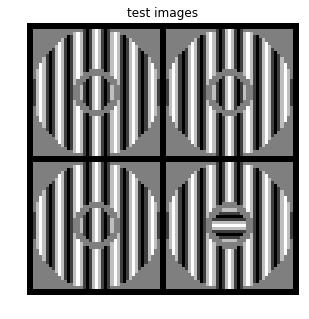

full
no_lgn
no_inhibition


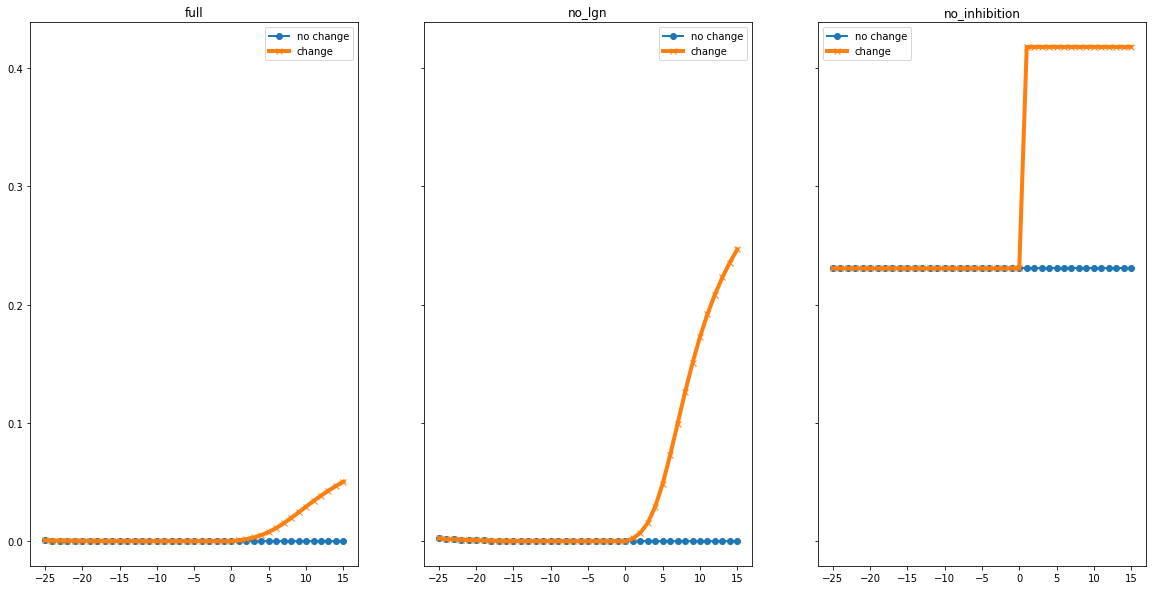

In [8]:
fig4b()

In [9]:
# the paper uses simple cell and static grating in the figure.
# the paper also says that complex cell gives similar results.
# beloe are simple (right column in figure 4, figure number in windows are row numbers) vs. complex.
# I think the bump for complex doesn't look good, and it's not "similar" to simple.
# however, maybe the author doesn't consider that too much and focus on latency.
# not sure. see them for yourself.

# simple

![](./fig4_right_simple.png)

# complex

![](./fig4_right_complex.png)